In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
dataframe = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Concordia/Major Assignment 2/archive/AMZN.csv")

In [ ]:
dataclose = dataframe[['Close']].values.astype('float32')
scaler = MinMaxScaler()
dataclose = scaler.fit_transform(dataclose)

In [ ]:
sequence_length = 10
batch_size = 8
learning_rate = 0.001
epochs = 1000

In [ ]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

X_train, y_train = create_dataset(dataclose, lookback=sequence_length)
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)

<ipython-input-5-4317eda4bc22>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


In [ ]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        #x = x[:, -1, :]
        x = self.linear(x)
        return x

In [ ]:
model = AirModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
n_epochs = epochs
training_losses = []
for epoch in tqdm(range(n_epochs)):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_losses.append(running_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/ML Concordia/Major Assignment 2/saved models/2-LSTMmodel.h5')

In [ ]:
#model = torch.load('/content/drive/MyDrive/Colab Notebooks/ML Concordia/Major Assignment 2/saved models/2-LSTMmodel.h5')

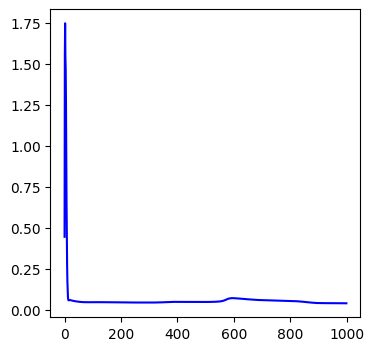

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(training_losses, c='b')
plt.show()

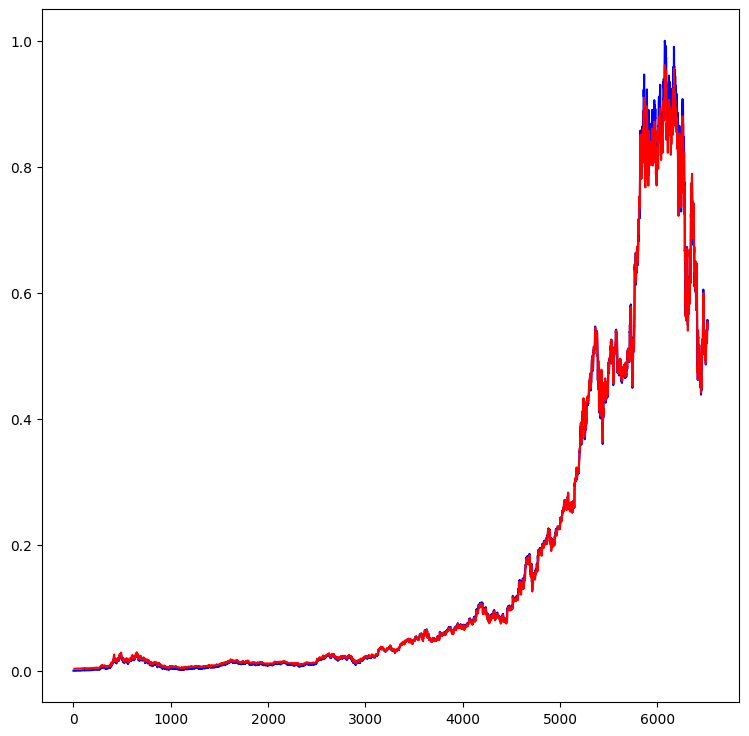

In [ ]:
with torch.no_grad():
  train_plot = np.ones_like(dataclose) * np.nan
  train_plot[sequence_length:len(dataclose)] = model(X_train)[:, -1, :]

plt.figure(figsize=(9, 9))
plt.plot(dataclose, c='b')
plt.plot(train_plot, c='r')
plt.show()